# Airbnb Rio de Janeiro - Regressão lognormal

# 1. Introdução

Esse notebook propõe aplicar um modelo de Regressão Lognormal para os [dados do Airbnb na cidade do Rio de Janeiro](https://insideairbnb.com/get-the-data/#:~:text=Rio%20de%20Janeiro%2C%20Rio%20de%20Janeiro%2C%20Brazil). 

Os dados são carregados do processo de [feature engineering](https://github.com/BPRateiro/rio-airbnb-data-analysis/blob/main/notebooks/feature_engineering.ipynb).Incluem informações detalhadas sobre a disponibilidade de listagens, características dos imóveis, interações de usuários, e preços. 

O objetivo principal é transformar essas informações para melhorar a capacidade preditiva de modelos de machine learning e facilitar análises mais profundas.

## 1.1 Configurações e bibliotecas

In [1]:
import pandas as pd
import statsmodels.api as sm
import statsmodels.formula.api as smf
import matplotlib.pyplot as plt
from sklearn.ensemble import IsolationForest
from distfit import distfit

## 1.2 Leitura dos dados

Removemos também colunas que tem apenas um valor

In [2]:
df_inicial = pd.read_parquet('../data/bronze/feature_engineering_output.parquet')
df_inicial.drop(columns=[col for col in df_inicial.columns if df_inicial[col].nunique() == 1], inplace=True)
df_inicial.head()

,accommodates,availability_365,availability_60,bathrooms,bedrooms,beds,calculated_host_listings_count_entire_homes,calculated_host_listings_count_private_rooms,calculated_host_listings_count_shared_rooms,days_since_first_review,...,neighbourhood_cleansed_laranjeiras,neighbourhood_cleansed_leblon,neighbourhood_cleansed_leme,neighbourhood_cleansed_recreio_dos_bandeirantes,neighbourhood_cleansed_santa_teresa,neighbourhood_cleansed_tijuca,neighbourhood_cleansed_outros,room_type_hotel_room,room_type_private_room,room_type_shared_room
0,5.0,269.0,59.0,2.0,1.0,2.0,1.0,0.0,0.0,131.8,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
1,4.0,176.0,56.0,2.0,2.0,0.0,6.0,0.0,0.0,173.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,2.0,267.0,59.0,1.0,1.0,1.0,0.0,2.0,0.0,151.4,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
3,2.0,38.0,35.0,1.0,1.0,1.0,1.0,1.0,0.0,531.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
4,5.0,10.0,10.0,2.0,2.0,3.0,1.0,0.0,0.0,3631.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


# 2. Outliers na variável resposta

A variável preço contém outliers com valores muito altos ou até mesmo nulos. Nesse estudo, optamos por remover esses outliers.

Optamos por modelar os dados com uma lognormal, apesar que genextreme aparentemente tem um melhor ajuste aos dados.

Nenhum dos modelos populares passa no teste de 

Tamanho do dataset de outliers: 268
Tamanho do dataset de dados normais: 26690


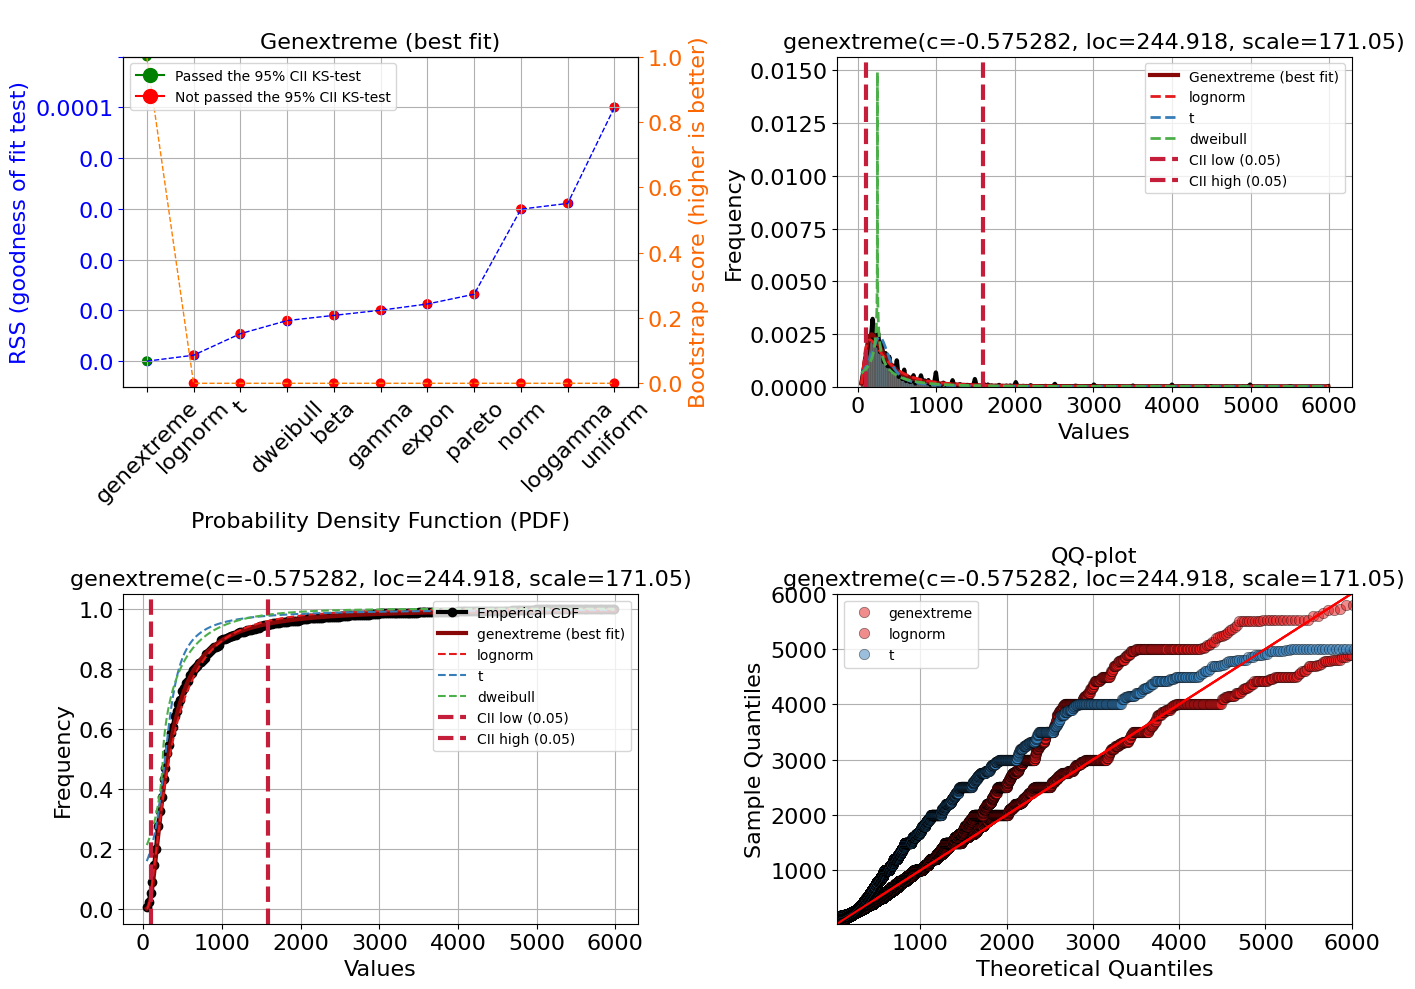

In [3]:
df_detect = df_inicial.copy()

# Modelo para identificar outliers usando o preço como DataFrame
iso_forest = IsolationForest(contamination=0.01, random_state=75)
iso_forest.fit(df_inicial[['price']]) 

# Prever outliers
df_detect['is_outlier'] = iso_forest.predict(df_detect[['price']])

# Identificar registros com preço igual a 0
price_zero = df_detect[df_detect['price'] == 0]

# Separar os dados normais e outliers identificados pelo modelo
df_outliers = df_detect[df_detect['is_outlier'] == -1]
df_normais = df_detect[df_detect['is_outlier'] == 1]

# Combinar outliers identificados pelo modelo com registros cujo preço é 0
df_outliers = pd.concat([df_outliers, price_zero]).drop_duplicates()

# Atualizar o conjunto de dados normais removendo aqueles cujo preço é 0
df_normais = df_normais[~df_normais.index.isin(df_outliers.index)]

# Imprimir o tamanho dos datasets
print(f"Tamanho do dataset de outliers: {len(df_outliers)}")
print(f"Tamanho do dataset de dados normais: {len(df_normais)}")

# Removendo variável auxiliar
df_outliers.drop(columns=['is_outlier'], inplace=True)
df_normais.drop(columns=['is_outlier'], inplace=True)

# Testar a melhor distribuição para os dados que não são outliers
dfit = distfit(alpha=.05, distr='popular', random_state=75, verbose=False)
dfit.fit_transform(df_normais['price'].values, verbose=False)
dfit.bootstrap(
    X=df_normais['price'].values, 
    n_boots=100, 
    alpha=0.05,
    n=10_000,
    n_top=3, 
    update_model=True
)

# Plotar o resumo das distribuições
fig, axs = plt.subplots(2, 2, figsize=(14, 10))
dfit.plot_summary(ax=axs[0, 0])
dfit.plot(chart='pdf', n_top=3, ax=axs[0, 1])
dfit.plot(chart='cdf', n_top=3, ax=axs[1, 0]) 
qq_ax = axs[1, 1]
dfit.qqplot(df_normais['price'].values, n_top=3, ax=qq_ax)
price_min = df_normais['price'].min()
price_max = df_normais['price'].max()
qq_ax.set_ylim([price_min, price_max])
qq_ax.set_xlim([price_min, price_max])

# Melhorar o layout e exibir o gráfico
plt.tight_layout()
plt.show()

# 3. Modelo inicial

Vimos durante o EDA que `price` melhor se adequa à distribuição lognormal, considerando todos os valores de price como reais. Utilizaremos um modelo linear generalizado (GLM) adequado à variável resposta, evitando-se transformações nas variáveis e preservando a interpretabilidade.

In [4]:
# Redefinir a variável resposta e as preditoras
X = df_normais.drop(columns=['price'])
y = df_normais['price']

# Adicionar uma constante para o intercepto no modelo
X = sm.add_constant(X)

# Ajustar o modelo GLM com a função de ligação log
glm_model = sm.GLM(y, X, family=sm.families.Gaussian(link=sm.families.links.log())).fit()

# Obter o resumo do modelo
glm_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                 Generalized Linear Model Regression Results                  
==============================================================================
Dep. Variable:                  price   No. Observations:                26690
Model:                            GLM   Df Residuals:                    26630
Model Family:                Gaussian   Df Model:                           59
Link Function:                    log   Scale:                      2.3699e+05
Method:                          IRLS   Log-Likelihood:            -2.0300e+05
Date:                Tue, 06 Aug 2024   Deviance:                   6.3110e+09
Time:                        18:37:03   Pearson chi2:                 6.31e+09
No. Iterations:                   100   Pseudo R-squ. (CS):             0.5996
Covariance Type:            nonrobust                                         
===================================================================================================================
                                                      coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------------------------------------
const                                               3.7808      0.097     38.957      0.000       3.591       3.971
accommodates                                        0.0672      0.002     36.641      0.000       0.064       0.071
availability_365                                    0.0007   4.46e-05     16.667      0.000       0.001       0.001
availability_60                                     0.0018      0.000      5.922      0.000       0.001       0.002
bathrooms                                           0.1128      0.004     29.069      0.000       0.105       0.120
bedrooms                                            0.0388      0.004      8.854      0.000       0.030       0.047
beds                                               -0.0066      0.001     -5.207      0.000      -0.009      -0.004
calculated_host_listings_count_entire_homes      7.216e-05      0.000      0.294      0.769      -0.000       0.001
calculated_host_listings_count_private_rooms       -0.0571      0.005    -10.555      0.000      -0.068      -0.047
calculated_host_listings_count_shared_rooms        -0.0198      0.013     -1.551      0.121      -0.045       0.005
days_since_first_review                            -0.0001   8.26e-06    -12.134      0.000      -0.000    -8.4e-05
days_since_host_active                           4.254e-05   4.57e-06      9.307      0.000    3.36e-05    5.15e-05
days_since_last_review                              0.0003   9.98e-06     31.905      0.000       0.000       0.000
description_length                                  0.0001   2.84e-05      4.757      0.000    7.95e-05       0.000
host_about_length                                1.061e-05   1.46e-05      0.725      0.469   -1.81e-05    3.93e-05
host_acceptance_rate                                0.0274      0.017      1.580      0.114      -0.007       0.061
host_has_profile_pic                               -0.0178      0.027     -0.668      0.504      -0.070       0.035
host_identity_verified                              0.0387      0.012      3.338      0.001       0.016       0.062
host_is_superhost                                   0.1440      0.014     10.395      0.000       0.117       0.171
host_listings_count                              4.711e-05   4.54e-05      1.038      0.299   -4.19e-05       0.000
host_responded                                      1.6940      0.050     33.939      0.000       1.596       1.792
instant_bookable                                    0.0631      0.012      5.130      0.000       0.039       0.087
maximum_nights                                  -4.461e-05   1.98e-05     -2.249      0.025   -8.35e-05   -5.73e-06
maximum_nights_avg_ntm                          -5.269e-05   1.89e-

# 4. Avaliação das premissas

In [7]:
from statsmodels.stats.stattools import durbin_watson
from scipy.stats import shapiro, kstest
from statsmodels.stats.diagnostic import het_breuschpagan, het_white

# Obter resíduos
residuals = glm_model.resid_response

# Teste de Independência dos Erros
dw_statistic = durbin_watson(residuals)
print(f"Estatística de Durbin-Watson: {dw_statistic}")

# Teste de Normalidade dos Resíduos
ks_stat, ks_p = kstest(residuals, 'norm', args=(residuals.mean(), residuals.std()))
print(f"Teste de Kolmogorov-Smirnov: estatística = {ks_stat}, valor-p = {ks_p}")

# Teste de Homoscedasticidade
bp_test = het_breuschpagan(residuals, glm_model.model.exog)
print(f"Teste de Breusch-Pagan: estatística LM = {bp_test[0]}, valor-p = {bp_test[1]}")

# Adequação do Modelo
print(f"AIC: {glm_model.aic}")
print(f"BIC: {glm_model.bic}")

Estatística de Durbin-Watson: 1.9922691778095782
Teste de Kolmogorov-Smirnov: estatística = 0.21312592137636, valor-p = 0.0
Teste de Breusch-Pagan: estatística LM = 2588.453904086076, valor-p = 0.0
AIC: 406111.9547062845
BIC: 6310684422.692492
